In [1]:
import pandas as pd
import datetime as dt
import random as rnd
import numpy as np
import matplotlib.pyplot as plt
import statistics as stat
plt.style.use('fivethirtyeight')

In [2]:
elo_df = pd.read_csv(r'data\elo_data_set.csv', parse_dates=[0])
teams = []
for i in elo_df['team'].unique(): #constructs list of team names
    teams.append(i)
elo_df.head()

,datetime,team,season,opp,day_week,week,W/L,ot,record,home/away,...,defense_expected_points,sp_expected_points,team_elo_before_all,team_elo_after_all,opp_elo_before_all,opp_elo_after_all,team_elo_before_season,team_elo_after_season,opp_elo_before_season,opp_elo_after_season
0,2002-09-05 20:38:00,NYG,2002,SFO,Thu,1,0.0,0.0,0-1,HOME,...,-0.79,3.46,1500.0,1485.0,1500.0,1515.0,1500.0,1480.0,1500.0,1520.0
1,2002-09-08 13:04:00,CAR,2002,BAL,Sun,1,1.0,0.0,1-0,HOME,...,6.68,4.20,1500.0,1515.0,1500.0,1485.0,1500.0,1520.0,1500.0,1480.0
2,2002-09-08 13:04:00,CHI,2002,MIN,Sun,1,1.0,0.0,1-0,HOME,...,-1.20,1.01,1500.0,1515.0,1500.0,1485.0,1500.0,1520.0,1500.0,1480.0
3,2002-09-08 13:04:00,CLE,2002,KAN,Sun,1,0.0,0.0,0-1,HOME,...,-17.94,1.15,1500.0,1485.0,1500.0,1515.0,1500.0,1480.0,1500.0,1520.0
4,2002-09-08 13:04:00,BUF,2002,NYJ,Sun,1,0.0,1.0,0-1,HOME,...,0.59,-7.81,1500.0,1485.0,1500.0,1515.0,1500.0,1480.0,1500.0,1520.0


In [3]:
# separates out played games, and the upcoming week.
#season_df = elo_df[elo_df['season']==dt.datetime.today()]
season_df = elo_df[elo_df['season']==dt.datetime.today().year]

history_df = elo_df[elo_df['datetime'] < dt.datetime.today()]

future_df = season_df[season_df['datetime'] >= dt.datetime.today()]


upcoming_week = history_df['week'].iloc[-1] + 1
future_df = future_df[future_df['week'] == upcoming_week]
future_df = future_df[['datetime', 'team', 'opp', 'team_score', 'opp_score', 'team_elo_before_all', 'opp_elo_before_all', 'team_elo_before_season', 'opp_elo_before_season', 'W/L']]
print(f'Week to predict : {upcoming_week}')

Week to predict : 13


In [4]:
# Generates a dictionary of dataframes for points gained/allowed per team. This allows convenient generation of the distributions fed into the game 
team_data_dict_all = {}
team_data_dict_season = {}
for i in range(len(teams)):
    team = teams[i]
    team_data_all = pd.DataFrame()
    team_data_season = pd.DataFrame()
    
    team_off_all = []
    team_def_all = []
    team_elo_all = []
    
    team_off_season = []
    team_def_season = []
    team_elo_season = []
    
    team_df_all = history_df[(history_df['team'] == f'{team}') | (history_df['opp'] == f'{team}')]
    team_df_season = season_df[(season_df['team'] == f'{team}') | (season_df['opp'] == f'{team}')]
    team_df_all.reset_index(inplace=True)
    team_df_all.drop('index', axis=1, inplace=True)
    
    team_df_season.reset_index(inplace=True)
    team_df_season.drop('index', axis=1, inplace=True)
    
    for x in range(len(team_df_all)):
        if team_df_all['team'].iloc[x] == f'{team}':
            team_off_all.append(team_df_all['team_score'][x])
            team_def_all.append(team_df_all['opp_score'][x])
            team_elo_all.append(team_df_all['team_elo_before_all'][x])
        else:
            team_off_all.append(team_df_all['opp_score'][x])
            team_def_all.append(team_df_all['team_score'][x])
            team_elo_all.append(team_df_all['opp_elo_before_all'][x])
            
    for y in range(len(team_df_season)):
        if team_df_all['team'].iloc[y] == f'{team}':
            team_off_season.append(team_df_season['team_score'][y])
            team_def_season.append(team_df_season['opp_score'][y])
            team_elo_season.append(team_df_season['team_elo_before_all'][y])
        else:
            team_off_season.append(team_df_season['opp_score'][y])
            team_def_season.append(team_df_season['team_score'][y])
            team_elo_season.append(team_df_season['opp_elo_before_all'][y])
    
    team_data_all['team_off'] = team_off_all
    team_data_all['team_def'] = team_def_all
    team_data_all['elo'] = team_elo_all
    team_data_dict_all[team] = team_data_all
    
    team_data_season['team_off'] = team_off_season
    team_data_season['team_def'] = team_def_season
    team_data_season['elo'] = team_elo_season
    team_data_season.dropna(inplace=True)
    team_data_dict_season[team] = team_data_season
      
   
print(len(team_data_dict_all.keys()), ' ' , len(team_data_dict_season.keys()))

C:\Users\fitzp\Anaconda3\lib\site-packages\pandas\core\frame.py:3997: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


32   32


In [5]:
team_data_dict_all['NYJ']

,team_off,team_def,elo
0,37.0,31.0,1500.000000
1,7.0,44.0,1515.000000
2,3.0,30.0,1500.000000
3,3.0,28.0,1486.291995
4,25.0,29.0,1471.939195
...,...,...,...
305,10.0,18.0,1335.921036
306,9.0,35.0,1328.358673
307,27.0,30.0,1325.617368
308,28.0,34.0,1320.625259


In [6]:
# Games to be predicted
future_df.reset_index(inplace=True)
future_df.drop('index', axis=1, inplace=True)
future_df['team_elo_prediction_all%'] = np.nan
future_df['opp_elo_prediction_all%'] = np.nan
future_df['team_gauss_prediction_all%'] = np.nan
future_df['opp_gauss_prediction_all%'] = np.nan
future_df['tie_gauss_prediction_all%'] = np.nan

future_df['team_elo_prediction_season%'] = np.nan
future_df['opp_elo_prediction_season%'] = np.nan
future_df['team_gauss_prediction_season%'] = np.nan
future_df['opp_gauss_prediction_season%'] = np.nan
future_df['tie_gauss_prediction_season%'] = np.nan

future_df

,datetime,team,opp,team_score,opp_score,team_elo_before_all,opp_elo_before_all,team_elo_before_season,opp_elo_before_season,W/L,team_elo_prediction_all%,opp_elo_prediction_all%,team_gauss_prediction_all%,opp_gauss_prediction_all%,tie_gauss_prediction_all%,team_elo_prediction_season%,opp_elo_prediction_season%,team_gauss_prediction_season%,opp_gauss_prediction_season%,tie_gauss_prediction_season%
0,2020-12-06 13:00:00,MIN,JAX,NaN,NaN,1554.345440,1305.907960,1419.435983,1535.433186,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2020-12-06 13:00:00,HOU,IND,NaN,NaN,1512.930307,1516.457894,1408.824709,1422.414676,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2020-12-06 13:00:00,MIA,CIN,NaN,NaN,1476.450410,1293.585801,1447.459941,1464.563850,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2020-12-06 13:00:00,ATL,NOR,NaN,NaN,1495.171083,1696.114499,1443.508365,1445.409006,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2020-12-06 13:00:00,TEN,CLE,NaN,NaN,1598.675889,1448.188020,1478.742652,1403.860863,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,2020-12-06 13:00:00,NYJ,LVR,NaN,NaN,1300.386795,1466.619776,1407.270987,1508.864885,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,2020-12-06 13:00:00,CHI,DET,NaN,NaN,1494.527467,1374.707407,1442.980399,1547.505101,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,2020-12-06 16:05:00,SEA,NYG,NaN,NaN,1631.517710,1368.593968,1397.131880,1468.829204,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,2020-12-06 16:05:00,ARI,LAR,NaN,NaN,1445.264048,1587.498740,1493.753019,1474.622380,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,2020-12-06 16:25:00,LAC,NWE,NaN,NaN,1401.730996,1615.531349,1525.616861,1521.200148,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [7]:
# functions to simulate games

def elo_expected(teamA, teamB, dictionary):
    rating_A = dictionary[teamA]['elo'].iloc[-1]
    rating_B = dictionary[teamB]['elo'].iloc[-1]
    expected_A = 1 / (1 + 10 ** ((rating_B - rating_A) / 400 ))
    expected_B = 1 / (1 + 10 ** ((rating_A - rating_B) / 400 ))
    return [expected_A, expected_B]

def elo_game_sim(teamA, teamB, dictionary):
    win_values = elo_expected(teamA, teamB, dictionary)
    win_gen = rnd.random()
    if win_values[0] > win_values[1]:
        if win_gen < win_values[0]:
            return [1, 0]
        else:
            return [0, 1]
    if win_values[0] < win_values[1]:
        if win_gen < win_values[1]:
            return [0, 1]
        else:
            return[1, 0]

def elo_series_sim(teamA, teamB, runs, dictionary):
    games = []
    teamA_wins = 0
    teamB_wins = 0
    for i in range(runs):
        game = elo_game_sim(teamA, teamB, dictionary)
        games.append(game)
        if game[0] == 1:
            teamA_wins += 1
        else:
            teamB_wins += 1
    return [teamA_wins, teamB_wins]


"""
This one requires a bit of explanation. Because football scores are not normally distributed (due to coming in chunks of 3 and 7),
I took 100 samples from the data, and took the means of the samples. The distribution of that will be normal due to the 
Central Limit Theorem.

What it then does is feeds that in the random module's guassian function, which uses the average of the means of the samples, and the standard deviation of
the whole set.
"""


def gauss_game_sim(teamA, teamB, dictionary):
    """team_A_sample_means_off = []
    team_A_sample_means_def = []
    team_B_sample_means_off = []
    team_B_sample_means_def = []
    for i in range(30):
        team_A_sample_means_off.append(dictionary[teamA]['team_off'].sample(40, replace=True).mean())
        team_A_sample_means_def.append(dictionary[teamA]['team_def'].sample(40, replace=True).mean())
        team_B_sample_means_off.append(dictionary[teamB]['team_off'].sample(40, replace=True).mean())
        team_B_sample_means_def.append(dictionary[teamB]['team_def'].sample(40, replace=True).mean()) """

    
    #team_A_score = ((rnd.gauss(stat.mean(team_A_sample_means_off), dictionary[teamA]['team_off'].std())) + (rnd.gauss(stat.mean(team_B_sample_means_def), dictionary[teamB]['team_def'].std())))/2
    #team_B_score = ((rnd.gauss(stat.mean(team_B_sample_means_off), dictionary[teamB]['team_off'].std())) + (rnd.gauss(stat.mean(team_A_sample_means_def), dictionary[teamA]['team_def'].std())))/2
    team_A_score = (rnd.gauss(dictionary[teamA]['team_off'].mean(), dictionary[teamA]['team_off'].std()) + rnd.gauss(dictionary[teamB]['team_def'].mean(), dictionary[teamB]['team_def'].std()))/2
    team_B_score = (rnd.gauss(dictionary[teamB]['team_off'].mean(), dictionary[teamB]['team_off'].std()) + rnd.gauss(dictionary[teamA]['team_def'].mean(), dictionary[teamA]['team_def'].std()))/2
    if int(round(team_A_score)) > int(round(team_B_score)):
        return 1
    elif int(round(team_A_score)) < int(round(team_B_score)):
        return -1
    else: 
        return 0

def gauss_series_sim(teamA, teamB, runs, dictionary):
    games = []
    teamA_wins = 0
    teamB_wins = 0
    ties = 0
    for i in range(runs):
        game = gauss_game_sim(teamA, teamB, dictionary)
        games.append(game)
        if game == 1:
            teamA_wins += 1
        elif game== -1:
            teamB_wins += 1
        else:
            gauss_game_sim(teamA, teamB, dictionary)
    return [teamA_wins, teamB_wins, ties]

In [8]:
gauss_game_sim('NYJ', 'CHI', team_data_dict_all)

1

In [9]:
%%time
# simulations and future_df update
num_sims = 10000
for i in range(len(future_df)):
    teamA = future_df['team'].iloc[i]
    teamB = future_df['opp'].iloc[i]
    
    elo_result = elo_series_sim(teamA, teamB, num_sims, team_data_dict_all)
    elo_result_A = elo_result[0] / (elo_result[0] + elo_result[1])
    elo_result_B = elo_result[1] / (elo_result[0] + elo_result[1])
    future_df['team_elo_prediction_all%'].iloc[i] = elo_result_A
    future_df['opp_elo_prediction_all%'].iloc[i] = elo_result_B
    
    gauss_result = gauss_series_sim(teamA, teamB, num_sims, team_data_dict_all)
    gauss_result_A = gauss_result[0] / (gauss_result[0] + gauss_result[1] + gauss_result[2])
    gauss_result_B = gauss_result[1] / (gauss_result[0] + gauss_result[1] + gauss_result[2])
    gauss_result_tie = gauss_result[2] / (gauss_result[0] + gauss_result[1] + gauss_result[2])
    future_df['team_gauss_prediction_all%'].iloc[i] = gauss_result_A
    future_df['opp_gauss_prediction_all%'].iloc[i] = gauss_result_B
    future_df['tie_gauss_prediction_all%'].iloc[i] = gauss_result_tie
    
    elo_result_season = elo_series_sim(teamA, teamB, num_sims, team_data_dict_season)
    elo_result_A_season = elo_result_season[0] / (elo_result_season[0] + elo_result_season[1])
    elo_result_B_season = elo_result_season[1] / (elo_result_season[0] + elo_result_season[1])
    future_df['team_elo_prediction_season%'].iloc[i] = elo_result_A_season
    future_df['opp_elo_prediction_season%'].iloc[i] = elo_result_B_season
    
    gauss_result_season = gauss_series_sim(teamA, teamB, num_sims, team_data_dict_season)
    gauss_result_A_season = gauss_result_season[0] / (gauss_result_season[0] + gauss_result_season[1] + gauss_result_season[2])
    gauss_result_B_season = gauss_result_season[1] / (gauss_result_season[0] + gauss_result_season[1] + gauss_result_season[2])
    gauss_result_tie_season = gauss_result_season[2] / (gauss_result_season[0] + gauss_result_season[1] + gauss_result_season[2])
    future_df['team_gauss_prediction_season%'].iloc[i] = gauss_result_A_season
    future_df['opp_gauss_prediction_season%'].iloc[i] = gauss_result_B_season
    future_df['tie_gauss_prediction_season%'].iloc[i] = gauss_result_tie_season
    
    print('-----------------------------------------------------------------------------')
    print(f'TEAMS : {teamA} | {teamB}')
    print(f'HISTORICAL PREDICTION: elo_result: {elo_result} | gaussian_result: {gauss_result}')
    print(f'SEASON PREDICTION: elo_result: {elo_result_season} | gaussian_result: {gauss_result_season}')

C:\Users\fitzp\Anaconda3\lib\site-packages\pandas\core\indexing.py:671: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


-----------------------------------------------------------------------------
TEAMS : MIN | JAX
HISTORICAL PREDICTION: elo_result: [7897, 2103] | gaussian_result: [5573, 4032, 0]
SEASON PREDICTION: elo_result: [4649, 5351] | gaussian_result: [4393, 5093, 0]
-----------------------------------------------------------------------------
TEAMS : HOU | IND
HISTORICAL PREDICTION: elo_result: [4670, 5330] | gaussian_result: [3893, 5726, 0]
SEASON PREDICTION: elo_result: [2355, 7645] | gaussian_result: [5387, 4221, 0]
-----------------------------------------------------------------------------
TEAMS : MIA | CIN
HISTORICAL PREDICTION: elo_result: [7129, 2871] | gaussian_result: [4574, 5067, 0]
SEASON PREDICTION: elo_result: [4342, 5658] | gaussian_result: [4760, 4850, 0]
-----------------------------------------------------------------------------
TEAMS : ATL | NOR
HISTORICAL PREDICTION: elo_result: [2326, 7674] | gaussian_result: [4315, 5318, 0]
SEASON PREDICTION: elo_result: [5332, 4668] | g

In [10]:
future_df

,datetime,team,opp,team_score,opp_score,team_elo_before_all,opp_elo_before_all,team_elo_before_season,opp_elo_before_season,W/L,team_elo_prediction_all%,opp_elo_prediction_all%,team_gauss_prediction_all%,opp_gauss_prediction_all%,tie_gauss_prediction_all%,team_elo_prediction_season%,opp_elo_prediction_season%,team_gauss_prediction_season%,opp_gauss_prediction_season%,tie_gauss_prediction_season%
0,2020-12-06 13:00:00,MIN,JAX,NaN,NaN,1554.345440,1305.907960,1419.435983,1535.433186,NaN,0.7897,0.2103,0.580219,0.419781,0.0,0.4649,0.5351,0.463104,0.536896,0.0
1,2020-12-06 13:00:00,HOU,IND,NaN,NaN,1512.930307,1516.457894,1408.824709,1422.414676,NaN,0.4670,0.5330,0.404720,0.595280,0.0,0.2355,0.7645,0.560679,0.439321,0.0
2,2020-12-06 13:00:00,MIA,CIN,NaN,NaN,1476.450410,1293.585801,1447.459941,1464.563850,NaN,0.7129,0.2871,0.474432,0.525568,0.0,0.4342,0.5658,0.495317,0.504683,0.0
3,2020-12-06 13:00:00,ATL,NOR,NaN,NaN,1495.171083,1696.114499,1443.508365,1445.409006,NaN,0.2326,0.7674,0.447939,0.552061,0.0,0.5332,0.4668,0.622327,0.377673,0.0
4,2020-12-06 13:00:00,TEN,CLE,NaN,NaN,1598.675889,1448.188020,1478.742652,1403.860863,NaN,0.7039,0.2961,0.571548,0.428452,0.0,0.7010,0.2990,0.380558,0.619442,0.0
5,2020-12-06 13:00:00,NYJ,LVR,NaN,NaN,1300.386795,1466.619776,1407.270987,1508.864885,NaN,0.2727,0.7273,0.571325,0.428675,0.0,0.2642,0.7358,0.437039,0.562961,0.0
6,2020-12-06 13:00:00,CHI,DET,NaN,NaN,1494.527467,1374.707407,1442.980399,1547.505101,NaN,0.6740,0.3260,0.565926,0.434074,0.0,0.6455,0.3545,0.405386,0.594614,0.0
7,2020-12-06 16:05:00,SEA,NYG,NaN,NaN,1631.517710,1368.593968,1397.131880,1468.829204,NaN,0.8127,0.1873,0.578657,0.421343,0.0,0.7009,0.2991,0.586505,0.413495,0.0
8,2020-12-06 16:05:00,ARI,LAR,NaN,NaN,1445.264048,1587.498740,1493.753019,1474.622380,NaN,0.3007,0.6993,0.513899,0.486101,0.0,0.6112,0.3888,0.398318,0.601682,0.0
9,2020-12-06 16:25:00,LAC,NWE,NaN,NaN,1401.730996,1615.531349,1525.616861,1521.200148,NaN,0.2451,0.7549,0.378876,0.621124,0.0,0.2471,0.7529,0.541097,0.458903,0.0


In [11]:
predictions = []
predicted_teams = []
home_predict = []
opp_predict =[]
margin = []

for i in range(len(future_df)):
    home = future_df["team_elo_prediction_all%"][i] + future_df["opp_gauss_prediction_all%"][i] + future_df["team_elo_prediction_season%"][i] + future_df["opp_elo_prediction_season%"][i]
    opp = future_df["opp_elo_prediction_all%"][i] + future_df["opp_gauss_prediction_all%"][i] + future_df["opp_elo_prediction_season%"][i] + future_df["opp_elo_prediction_season%"][i]
    
    if home > opp:
        predictions.append(0)
        predicted_teams.append(future_df['team'].iloc[i])
        home_predict.append(home)
        opp_predict.append(opp)
        margin.append(home - opp)
    else:
        predictions.append(1)
        predicted_teams.append(future_df['opp'].iloc[i])
        home_predict.append(home)
        opp_predict.append(opp)
        margin.append(opp - home)

future_df['home_sum_predict'] = home_predict
future_df['opp_sum_predict'] = opp_predict
future_df['margin'] = margin
future_df['predicted_team'] = predicted_teams        
future_df['predicted_outcome'] = predictions


In [12]:
future_df

,datetime,team,opp,team_score,opp_score,team_elo_before_all,opp_elo_before_all,team_elo_before_season,opp_elo_before_season,W/L,...,team_elo_prediction_season%,opp_elo_prediction_season%,team_gauss_prediction_season%,opp_gauss_prediction_season%,tie_gauss_prediction_season%,home_sum_predict,opp_sum_predict,margin,predicted_team,predicted_outcome
0,2020-12-06 13:00:00,MIN,JAX,NaN,NaN,1554.345440,1305.907960,1419.435983,1535.433186,NaN,...,0.4649,0.5351,0.463104,0.536896,0.0,2.209481,1.700281,0.5092,MIN,0
1,2020-12-06 13:00:00,HOU,IND,NaN,NaN,1512.930307,1516.457894,1408.824709,1422.414676,NaN,...,0.2355,0.7645,0.560679,0.439321,0.0,2.062280,2.657280,0.5950,IND,1
2,2020-12-06 13:00:00,MIA,CIN,NaN,NaN,1476.450410,1293.585801,1447.459941,1464.563850,NaN,...,0.4342,0.5658,0.495317,0.504683,0.0,2.238468,1.944268,0.2942,MIA,0
3,2020-12-06 13:00:00,ATL,NOR,NaN,NaN,1495.171083,1696.114499,1443.508365,1445.409006,NaN,...,0.5332,0.4668,0.622327,0.377673,0.0,1.784661,2.253061,0.4684,NOR,1
4,2020-12-06 13:00:00,TEN,CLE,NaN,NaN,1598.675889,1448.188020,1478.742652,1403.860863,NaN,...,0.7010,0.2990,0.380558,0.619442,0.0,2.132352,1.322552,0.8098,TEN,0
5,2020-12-06 13:00:00,NYJ,LVR,NaN,NaN,1300.386795,1466.619776,1407.270987,1508.864885,NaN,...,0.2642,0.7358,0.437039,0.562961,0.0,1.701375,2.627575,0.9262,LVR,1
6,2020-12-06 13:00:00,CHI,DET,NaN,NaN,1494.527467,1374.707407,1442.980399,1547.505101,NaN,...,0.6455,0.3545,0.405386,0.594614,0.0,2.108074,1.469074,0.6390,CHI,0
7,2020-12-06 16:05:00,SEA,NYG,NaN,NaN,1631.517710,1368.593968,1397.131880,1468.829204,NaN,...,0.7009,0.2991,0.586505,0.413495,0.0,2.234043,1.206843,1.0272,SEA,0
8,2020-12-06 16:05:00,ARI,LAR,NaN,NaN,1445.264048,1587.498740,1493.753019,1474.622380,NaN,...,0.6112,0.3888,0.398318,0.601682,0.0,1.786801,1.963001,0.1762,LAR,1
9,2020-12-06 16:25:00,LAC,NWE,NaN,NaN,1401.730996,1615.531349,1525.616861,1521.200148,NaN,...,0.2471,0.7529,0.541097,0.458903,0.0,1.866224,2.881824,1.0156,NWE,1


In [13]:
future_df.to_csv(f'data/predictions/{dt.datetime.today().date()}_week_{upcoming_week}_predictions.csv', index=False)

In [14]:
future_df.sort_values('margin',  ascending=False, inplace=True )

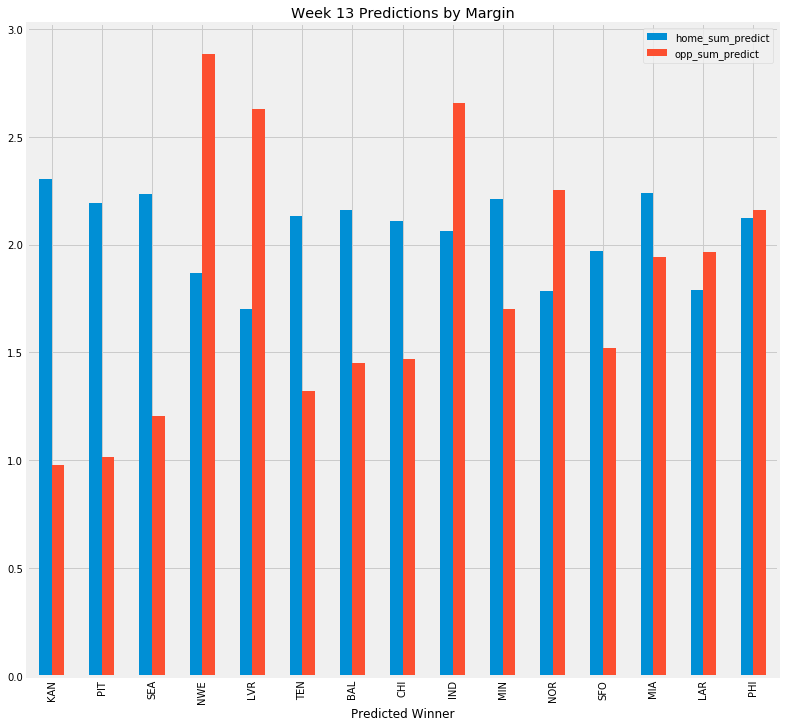

In [15]:
name_list = []
for i in range(len(future_df['datetime'])):
    if future_df['predicted_outcome'].iloc[i] == 0:
        name_list.append(future_df['team'].iloc[i])
    else:
        name_list.append(future_df['opp'].iloc[i])
    
future_df[['home_sum_predict', 'opp_sum_predict']].plot(kind='bar', figsize=(12, 12))
locs, labels=plt.xticks()
plt.xticks(locs, name_list)
plt.title(f'Week {upcoming_week} Predictions by Margin')
plt.xlabel('Predicted Winner')
plt.savefig('current_predictions.png')


plt.show()


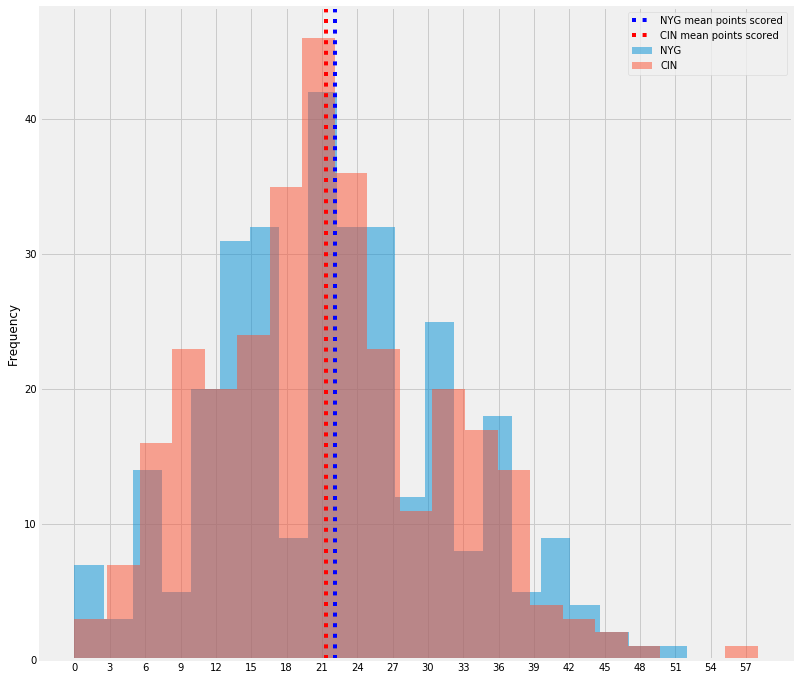

In [16]:
# these cells are just ways of accessing what the model is seeing for spot checks.
team1 = 'NYG'
team2 = 'CIN'

team_data_dict_all[team1]['team_off'].plot(kind='hist', figsize = (12,12), bins=21, alpha=0.5, label=team1)
team_data_dict_all[team2]['team_off'].plot(kind='hist', figsize = (12,12), bins=21, alpha=0.5, label=team2)
plt.axvline(team_data_dict_all[team1]['team_off'].mean(), linestyle=":", color='b', label = f'{team1} mean points scored')
plt.axvline(team_data_dict_all[team2]['team_off'].mean(), linestyle=':', color = 'r', label = f'{team2} mean points scored')
plt.xticks(range(0, 60, 3))
plt.legend()
plt.show()

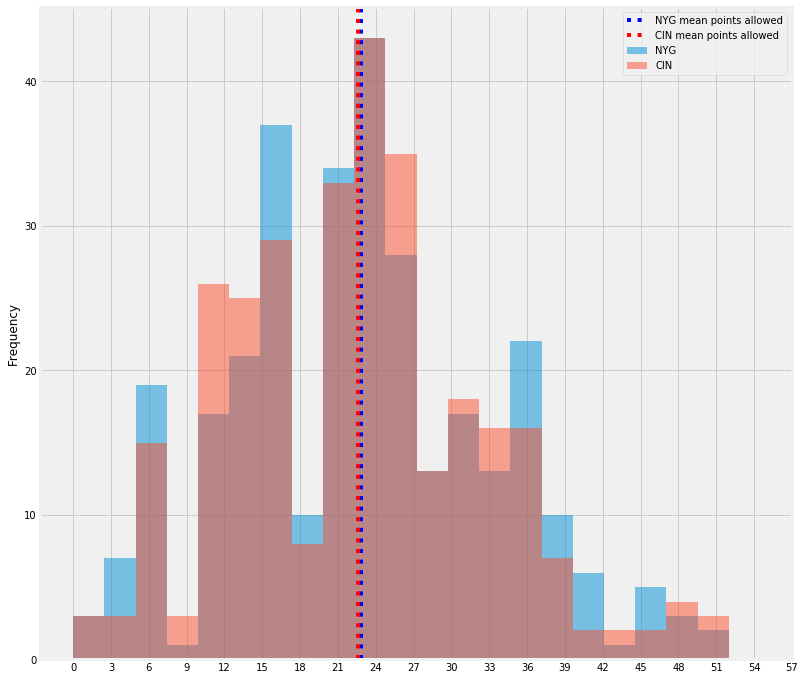

In [17]:
team_data_dict_all[team1]['team_def'].plot(kind='hist', figsize = (12,12), bins=21, alpha=0.5, label = team1)
team_data_dict_all[team2]['team_def'].plot(kind='hist', figsize = (12,12), bins=21, alpha=0.5, label = team2)
plt.axvline(team_data_dict_all[team1]['team_def'].mean(), linestyle=":", color='b', label = f'{team1} mean points allowed')
plt.axvline(team_data_dict_all[team2]['team_def'].mean(), linestyle=':', color = 'r', label = f'{team2} mean points allowed')
plt.xticks(range(0, 60, 3))
plt.legend()
plt.show()